In [10]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["major", "medium", "minor"]
result = classifier("missing parts", candidate_labels=labels)
print(result)

Device set to use cpu


{'sequence': 'missing parts', 'labels': ['medium', 'major', 'minor'], 'scores': [0.7015780210494995, 0.24842029809951782, 0.05000172555446625]}


In [11]:
result1=classifier("assembly", candidate_labels=labels)
print(result1)

{'sequence': 'assembly', 'labels': ['medium', 'major', 'minor'], 'scores': [0.46725407242774963, 0.39938992261886597, 0.1333560049533844]}


In [13]:
descriptions="bolt fixing"

In [12]:
def apply_domain_rules(description, result):
    # Apply domain-specific rules to adjust the classification if needed
    if "bolt" in description or "paint" in description:
        result['labels'] = ["Minor defect"]
    elif "damage" in description or "critical" in description:
        result['labels'] = ["Major defect"]
    return result

In [14]:

result = classifier(descriptions, labels)
final_result = apply_domain_rules(descriptions, result)
print(final_result)

{'sequence': 'bolt fixing', 'labels': ['major', 'medium', 'minor'], 'scores': [0.6657359600067139, 0.26089295744895935, 0.0733710378408432]}


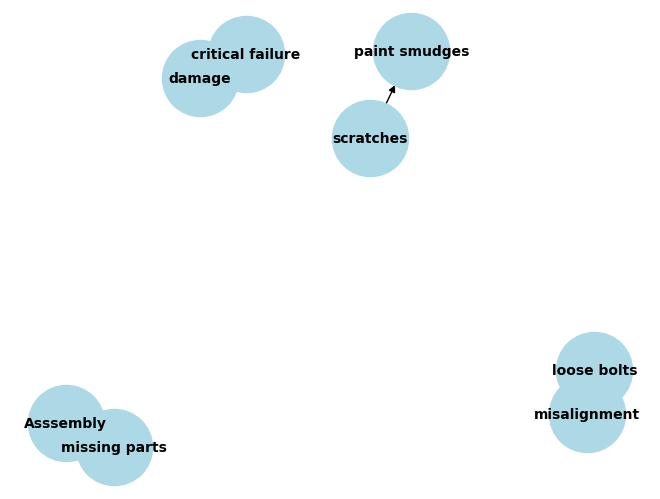

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes (defect types) and their associated severity
G.add_node("scratches", severity="Minor")
G.add_node("damage", severity="Major")
G.add_node("loose bolts", severity="Medium")
G.add_node("misalignment", severity="Medium")
G.add_node("missing parts", severity="Major")
G.add_node("paint smudges", severity="Minor")
G.add_node("critical failure", severity="Major")

# Add edges to define relationships
G.add_edge("scratches", "paint smudges", relation="similar_to")
G.add_edge("damage", "critical failure", relation="more_severe_than")
G.add_edge("loose bolts", "misalignment", relation="causes")
G.add_edge("misalignment", "loose bolts", relation="result_of")
G.add_edge("missing parts", "Asssembly", relation="result_of")

# Visualize the graph
nx.draw(G, with_labels=True, font_weight='bold', node_size=3000, node_color='lightblue', font_size=10)
plt.show()


In [7]:
import re

def map_description_to_knowledge_graph(description, graph):
    """
    Maps keywords from the description to the knowledge graph to determine severity.
    """
    # Preprocess the description (lowercase and split into words)
    description = description.lower()
    
    # Extract keywords from the description (you can also use NLP techniques like Named Entity Recognition)
    keywords = re.findall(r'\b\w+\b', description)
    
    # Find matching nodes (defect types) in the graph
    matched_severity = None
    for word in keywords:
        for node in graph.nodes:
            if word in node:
                severity = graph.nodes[node]['severity']
                if matched_severity is None:
                    matched_severity = severity
                elif severity == "Major":
                    matched_severity = "Major"  # Prioritize Major severity
                elif severity == "Medium" and matched_severity != "Major":
                    matched_severity = "Medium"
                elif severity == "Minor" and matched_severity not in ["Major", "Medium"]:
                    matched_severity = "Minor"
    
    return matched_severity

# Test with some defect descriptions
descriptions = [
    "process failure",
    "scratches",
    "dent",
    "Missing parts"
]

for desc in descriptions:
    severity = map_description_to_knowledge_graph(desc, G)
    print(f"Description: '{desc}' -> Predicted Severity: {severity}")


Description: 'process failure' -> Predicted Severity: Major
Description: 'scratches' -> Predicted Severity: Minor
Description: 'dent' -> Predicted Severity: None
Description: 'Missing parts' -> Predicted Severity: Major
